# Propagating fields for basic slab with complex refractive indices

All of the theory should go through (except now we need to divide by integral u^2 for guided modes and not integral norm(u)^2).  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact
from scipy.integrate import quad
from scipy.optimize import newton

%matplotlib widget
plt.style.use('dark_background')

In [2]:
A = SlabExact(symmetric=True, ns=np.array([1.4, 1.44, 1.4]) + .04j, Ts=[6, 2, 6],
             xrefs=[100, 50, 100])

Refractive index now has complex part.

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

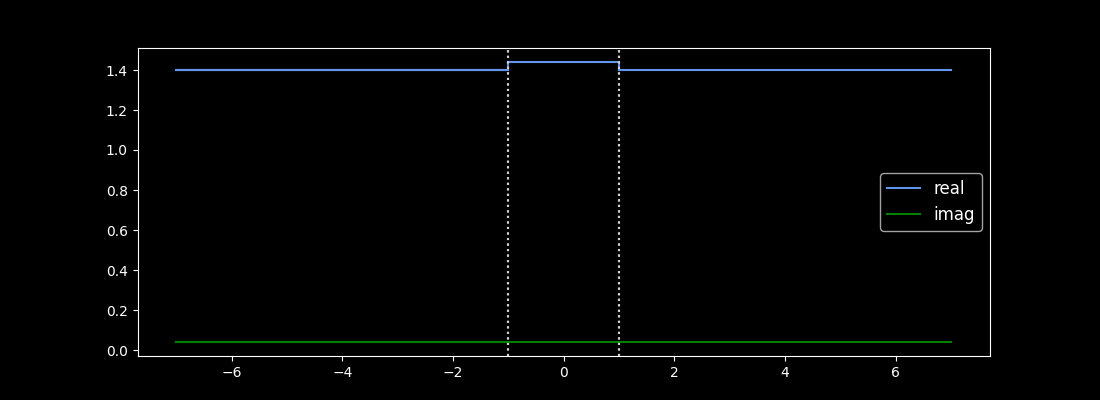

In [3]:
A.plot_refractive_index()
A.plot_refractive_index(ax=plt.gca(), part='imag', color='g')


Define input fields

In [4]:
b = .75
def quadratic_piecewise(x):
    conds = [(x<-b), ((-b<=x)*(x<=b)), (x>b)]
    funcs = [0, lambda x: 1 - (x/b)**2, 0]
    return np.piecewise(x, conds, funcs)
    
def quadratic_piecewise2d(x, zs=None, wavenumber=A.K0):
    conds = [(x<-b), ((-b<=x)*(x<=b)), (x>b)]
    funcs = [0, lambda x: 1 - (x/b)**2, 0]
    fx = np.piecewise(x, conds, funcs)
    fz = np.exp(1j * wavenumber * zs)
    return np.outer(fz, fx)

f0 = quadratic_piecewise

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

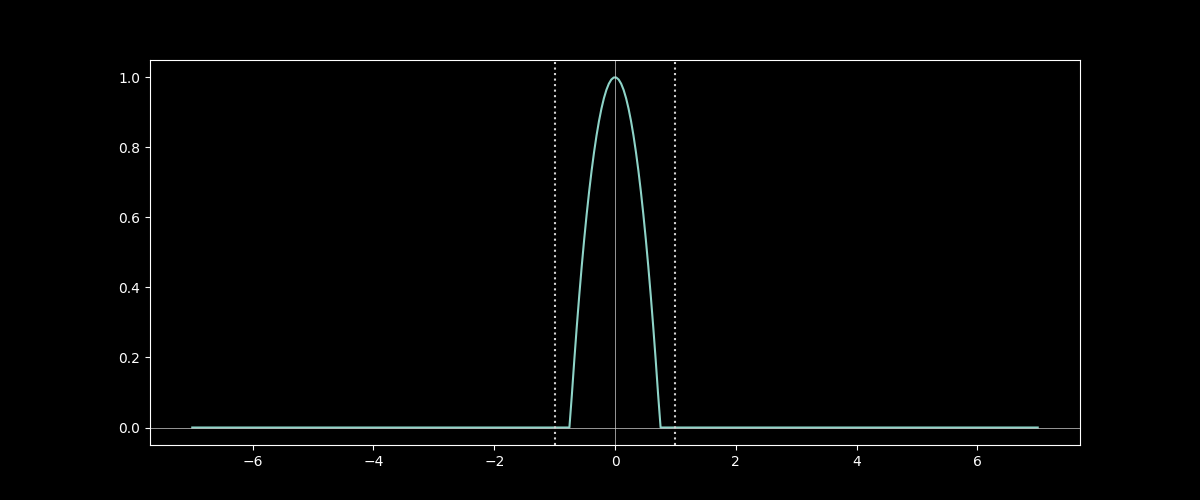

In [5]:
A.plot_field_1d(f0)

# "Guided" field

Here we find the guided component of the propagating fields.  We have quotes around guided because, due to the imaginary component of the refractive index, all fields will decay.

(<Figure size 1100x500 with 2 Axes>, <Axes: >)

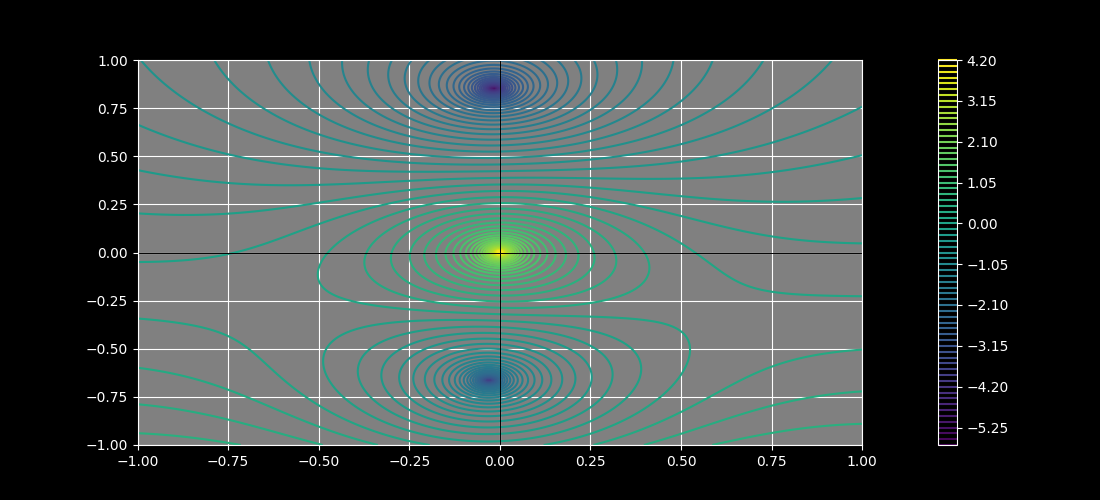

In [6]:
A.determinant_plot(-1, 1, -1, 1, mode_type='guided', plot_sdp=False)

In [7]:
Z_guided = newton(A.determinant_Z, np.array(.7j))
plt.plot(Z_guided.real, Z_guided.imag, marker='o')
Z_guided

(-0.017003981002434686+0.8527644226184199j)

In [8]:
F_guided = A.fields_Z(Z_guided, mode_type='guided')

In [9]:
d1 = quad(lambda x: F_guided(x)**2, -10, 10, complex_func=True)[0]
n1 = quad(lambda x: f0(x) * F_guided(x), -b, b, complex_func=True)[0]
cg1 = n1 / d1


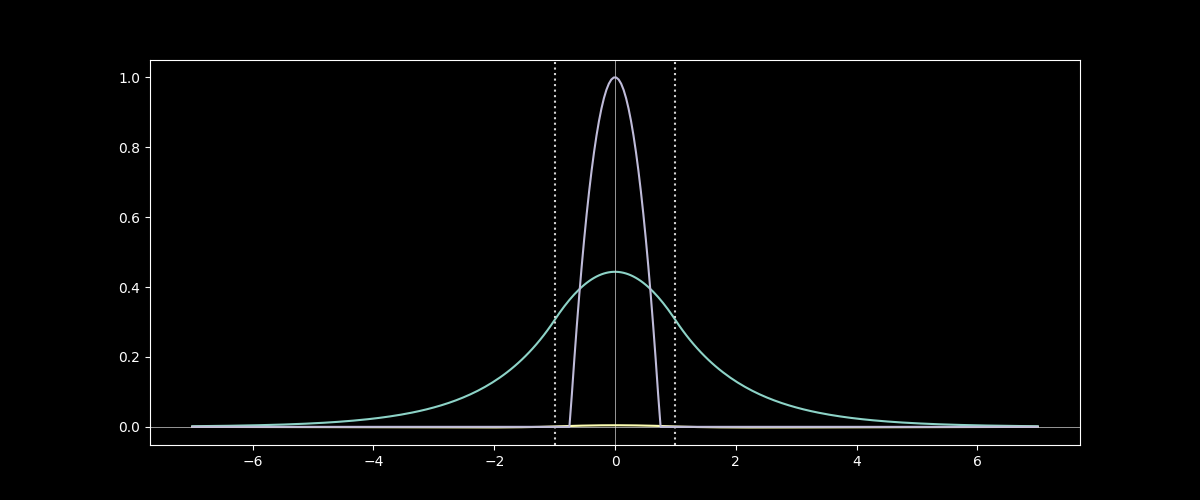

In [10]:
A.plot_field_1d(lambda x: cg1 * F_guided(x))
A.add_1d_plot(lambda x: cg1 * F_guided(x), part='imag')
A.add_1d_plot(f0)

# Propagation for radiation field

We find the radiation field by integrating along the positive real axis in the complex plane.  These positive real values are used as the transverse propagation constants to build the radiation modes (which are again all decaying due to imaginary component of refractive index).  Note that spectrum of this problem (real positive numbers) is same as for lossless problem (real refractive index).

In [11]:
Propagator = A.propagator()
paper_method = False

In [12]:
P1 = Propagator(A.real_contour(0.00001, A.Z_evanescent.real, 200), f0=quadratic_piecewise, Lx=-b, Rx=b, paper_method=paper_method)
P2 = Propagator(A.real_contour(A.Z_evanescent.real, A.Z_evanescent.real+3, 50), f0=quadratic_piecewise, Lx=-b, Rx=b, paper_method=paper_method)
P3 = Propagator(A.real_contour(A.Z_evanescent.real+3, 80, 500), f0=quadratic_piecewise, Lx=-b, Rx=b, paper_method=paper_method)
# P4 = Propagator(A.real_contour(80, 380, 1000), f0=quadratic_piecewise, Lx=-b, Rx=b, paper_method=paper_method)

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

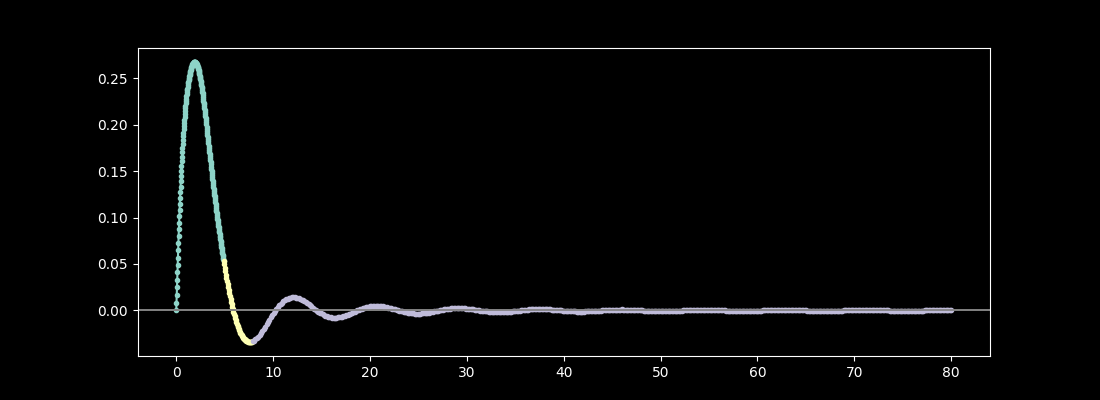

In [13]:
P1.plot_transform()
P2.plot_transform(ax=plt.gca())
P3.plot_transform(ax=plt.gca())
# P4.plot_transform(ax=plt.gca())


In [14]:
Ps = [
    P1,
    P2,
    P3,
    # P4,
]

In [15]:
x0 = 0
z0 = 0

guided_x = lambda x: cg1 * F_guided(x, z0)
guided_z = lambda z: cg1 * F_guided(x0, z)

rad_x = lambda x: sum([P.slice_propagate(x, z0, 'z') for P in Ps])
rad_z = lambda z: sum([P.slice_propagate(z, x0, 'x') for P in Ps])

full_x = lambda x: rad_x(x) + guided_x(x)
full_z = lambda z: rad_z(z) + guided_z(z)

Guided = lambda x, z: cg1 * F_guided(x, z)
Rad = lambda x, z: sum([P.propagate(x, z) for P in Ps])
Full = lambda x, z: Rad(x, z) + Guided(x, z)

### Visualizing Propagated Fields

We begin with the x cross section at the endface.  This should match the 

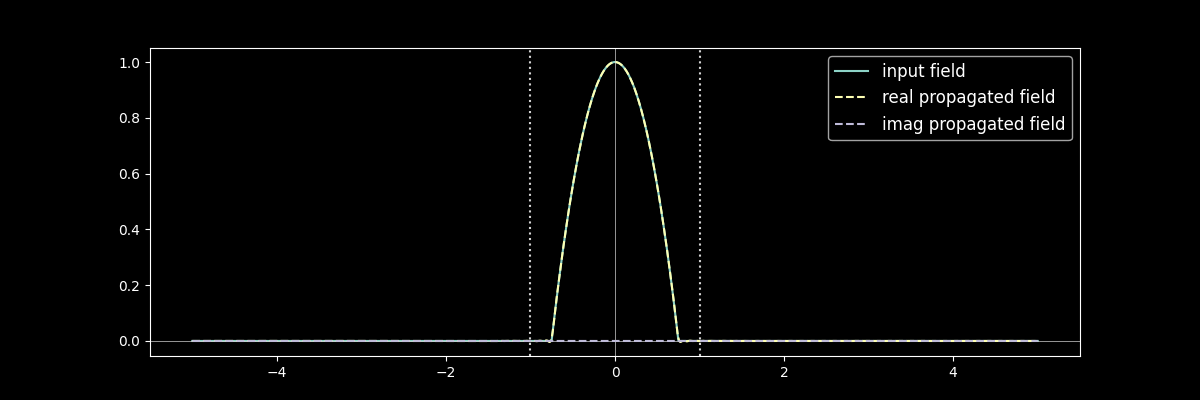

In [16]:
xs= np.linspace(-5, 5, 3000)
A.plot_field_1d(f0, xs=xs, figsize=(12,4), label='input field')
A.add_1d_plot(full_x, xs=xs, linestyle='--',  label='real propagated field')
A.add_1d_plot(full_x, xs=xs, linestyle='--', part='imag', label='imag propagated field')


Next we have a 2-d surface plot of the fields

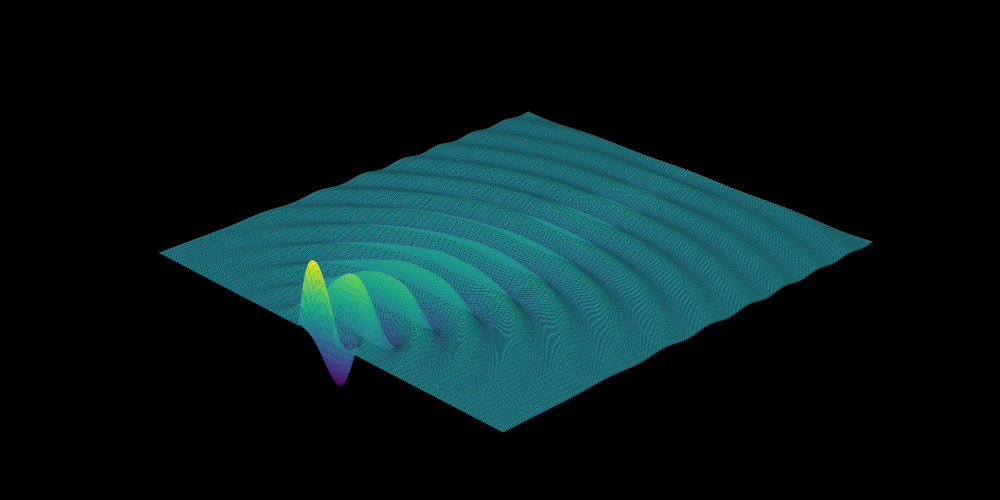

In [17]:
A.plot_field_2d_surface(Full, zmax=15, zref=350, zoom=2.5, elev=26, azim=-45, cstride=3, rstride=1);

Now we separate the above plot into the guided and radiation portions.  Note that there is no meaningful separation of the radiation field into propagating and evanescent types because all radiation modes decay when the refractive index is complex.

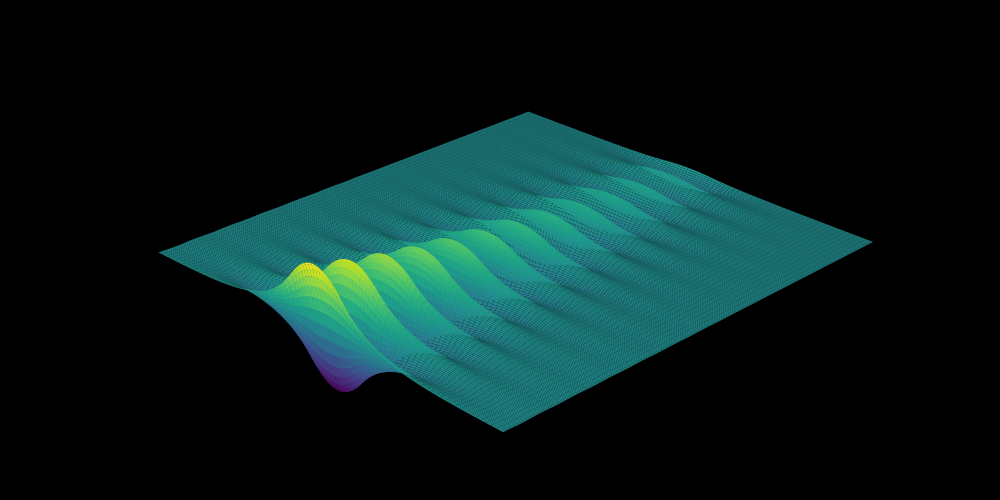

In [18]:
A.plot_field_2d_surface(Guided, zmax=15, zref=350, zoom=2.5, elev=26, azim=-45, cstride=3, rstride=1);

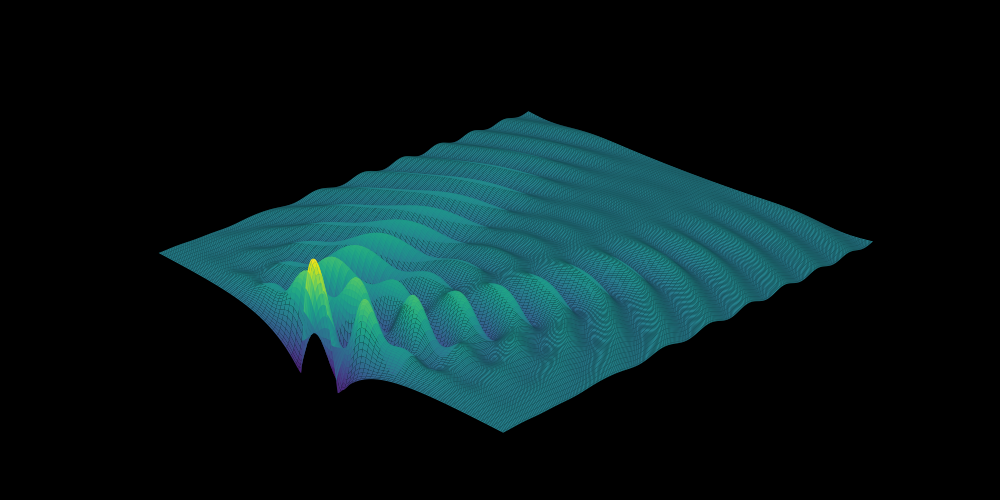

In [19]:
A.plot_field_2d_surface(Rad, zmax=15, zref=350, zoom=2.5, elev=26, azim=-45, cstride=3, rstride=1);

# Leaky Modes

We'll get all leaky modes between real axis and SDP path to find total leaky field.  We should then be able to integrate to a zero field by including the vertical portion and the SDP.

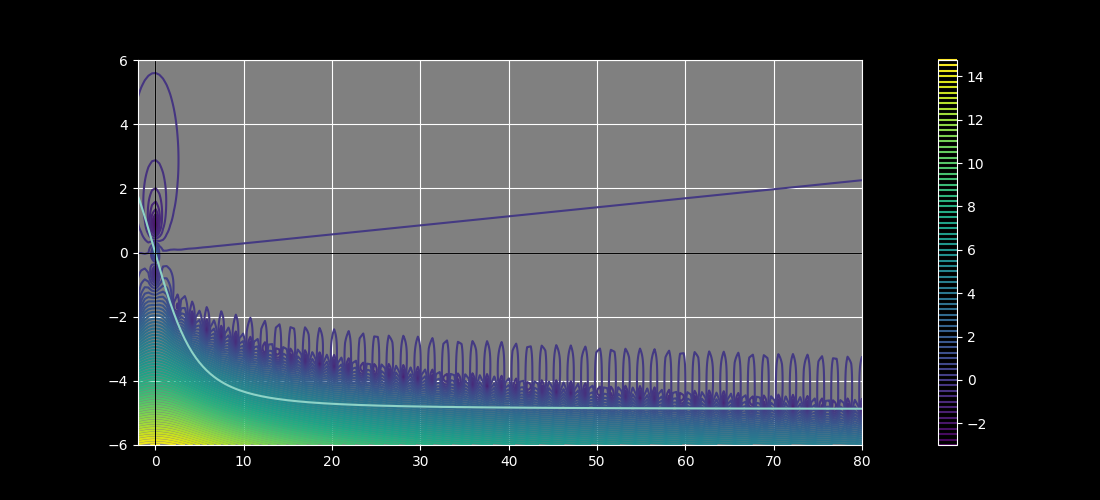

In [20]:
A.determinant_plot(-2, 80, -6, 6);

In [21]:
Z_guess = -np.array([
    -2.1 + 1.7j, -6 + 2.4j, -9 + 2.8j, -12.3 + 3.1j, -15.7 + 3.3j,
    -18.5 + 3.4j, -22 + 3.6j, -25 + 3.7j, -28 + 3.9j, -31.5 + 4j,
    -34 + 4.1j, -37.5 + 4.2j, -41 + 4.3j, -43.5 + 4.35j, -47.4 + 4.4j,
    -50 + 4.45j, -53 + 4.5j, -56.5 + 4.55j, -59.5 + 4.61j, -62.6 + 4.61j,
    -65.8 + 4.7j, -69.5 + 4.8j, -72.5 + 4.82j, -75 + 4.88j,
    # -78 + 4.9j,
])

In [22]:
Z_leakys = [newton(A.determinant_Z, np.array(Z), args=('TE', 'guided')) for Z in Z_guess]

for Z in Z_leakys:
    plt.plot(Z.real, Z.imag, marker='o')

In [23]:
# A.plot_field_1d(A.fields_Z(Z_leakys[1], mode_type='leaky', rounding=11), xs=np.linspace(-1.1, 1.1, 1000));

In [24]:
P_leaky = []

for Z in Z_leakys[:]:
    
    PZe = Propagator(A.circular_contour(Z, 1e-7, 6, 'cw'), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)
    P_leaky.append(PZe)
    
    if paper_method:
        PZo = Propagator(A.circular_contour(Z, 1e-7, 6, 'cw'), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)
        P_leaky.append(PZo)

In [25]:
leaky_x = lambda x: sum([P.slice_propagate(x, z0, 'z') for P in P_leaky])
leaky_z = lambda z: sum([P.slice_propagate(z, x0, 'x') for P in P_leaky])

diff_rad_leaky_x = lambda x: rad_x(x) - leaky_x(x)
diff_rad_leaky_z = lambda z: rad_z(z) - leaky_z(z)

Leaky = lambda x, z: sum([P.propagate(x, z) for P in P_leaky]) 

## Leaky and Radiation Fields at Input

At input, leaky field is similar in shape to radiation field, at least near the cetner of the core.  But we still need to include SDP (and possibly vertical) portion, so this makes sense.

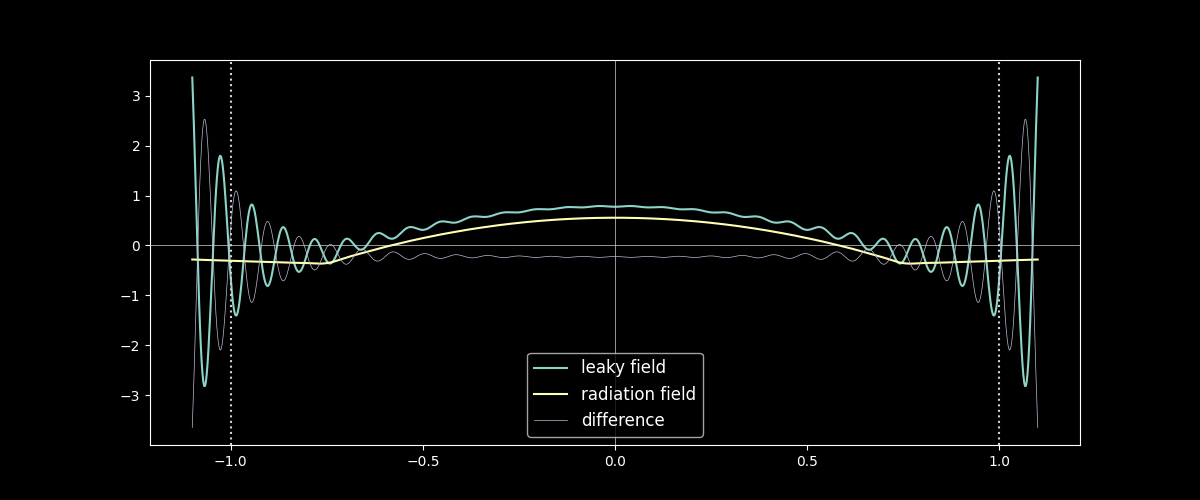

In [26]:
A.plot_field_1d(leaky_x, xs=np.linspace(-1.1, 1.1, 1000), label='leaky field')
A.add_1d_plot(rad_x, xs=np.linspace(-1.1, 1.1, 1000), label='radiation field')
A.add_1d_plot(diff_rad_leaky_x, xs=np.linspace(-1.1, 1.1, 1000), linewidth=.5, label='difference')

## Leaky and Radiation Field z-propagation

The SDP will play a large role in this as well.  Leaky field does not currently well approximate radiation field.

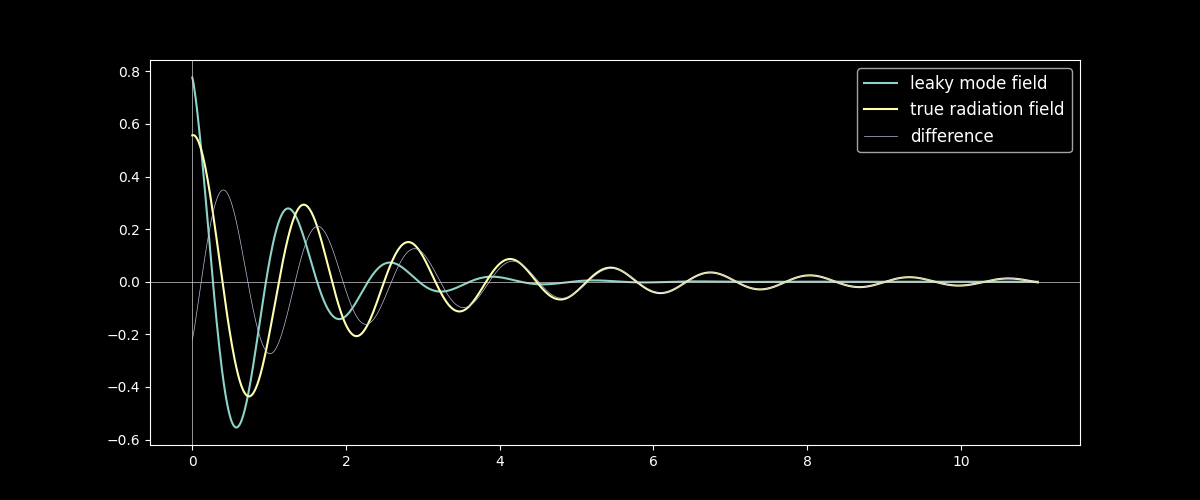

In [27]:
A.plot_field_1d(leaky_z, xs=np.linspace(0, 11, 1000), plot_Rhos=False, label='leaky mode field')
A.add_1d_plot(rad_z, xs=np.linspace(0, 11, 1000), label='true radiation field')
A.add_1d_plot(diff_rad_leaky_z, xs=np.linspace(0, 11, 1000), linewidth=.5, label='difference')

# SDP Path

We now propagate the fields along the SDP path.  We'll go out to $x=80$ to enclose all the leaky modes.

There is a lot of sign switching along the SDP path, so we check the spectral integrand to make sure it's smooth.

### Check spectral integrand

interactive(children=(FloatSlider(value=0.0, description='x', layout=Layout(width='90%'), max=7.0, min=-7.0, r…

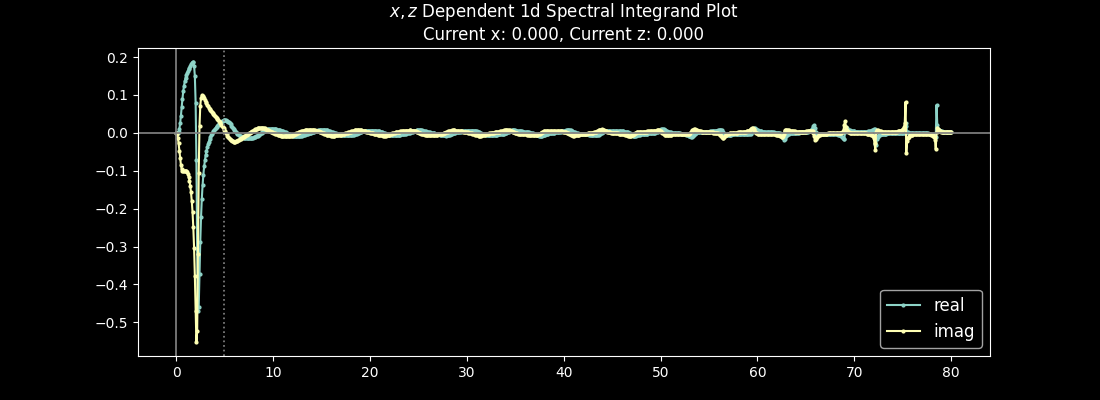

In [42]:
A.interactive_spectral_integrand_1d(A.sdp_contour(.00001, 80, 1000), f0=f0, Lx=-b, Rx=b, max_z=1, class_A_only=True, marker='o',
                                   markersize=2)

When $z=0$, the spectral integrand appears discontinuous.  But in fact if you zoom in, the spike areas are Lorentzian shaped:

interactive(children=(FloatSlider(value=0.0, description='x', layout=Layout(width='90%'), max=7.0, min=-7.0, r…

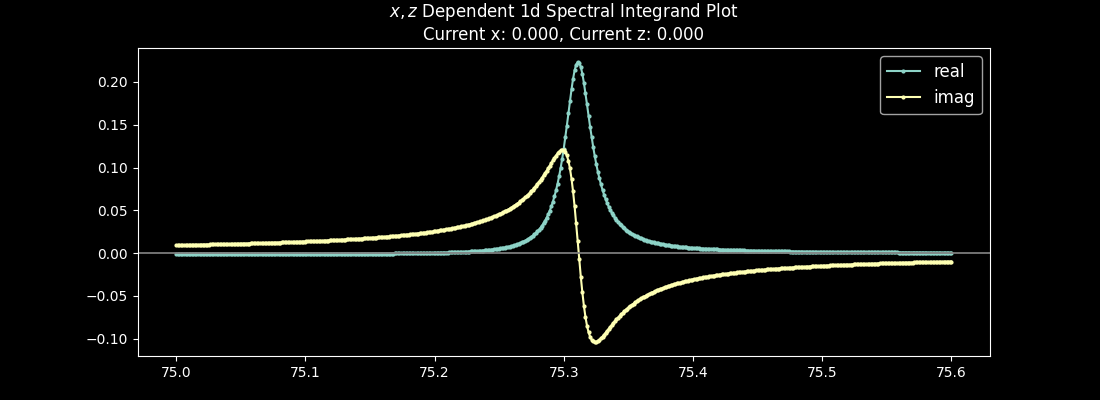

In [43]:
A.interactive_spectral_integrand_1d(A.sdp_contour(75, 75.6, 500), f0=f0, Lx=-b, Rx=b, plot_y_axis=False,
                                    plot_Z_evanescent=False, class_A_only=True, marker='o', markersize=2)

These spikes are smoothed to near triviality by increasing $z$ any amount.  But this does indicate that in order to capture the true SDP integral accurately for $z=0$ we will need a lot of resolution.

In [44]:
P_sdp1 = Propagator(A.sdp_contour(.00001, 1.8, 280), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp1o = Propagator(A.sdp_contour(.00001, 1.8, 280), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)

In [45]:
P_sdp2 = Propagator(A.sdp_contour(1.8, 2.6,  280), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp2o = Propagator(A.sdp_contour(1.8, 2.6,  280), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)

In [46]:
P_sdp3 = Propagator(A.sdp_contour(2.6, A.Z_evanescent.real, 280), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp3o = Propagator(A.sdp_contour(2.6, A.Z_evanescent.real,  280), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)


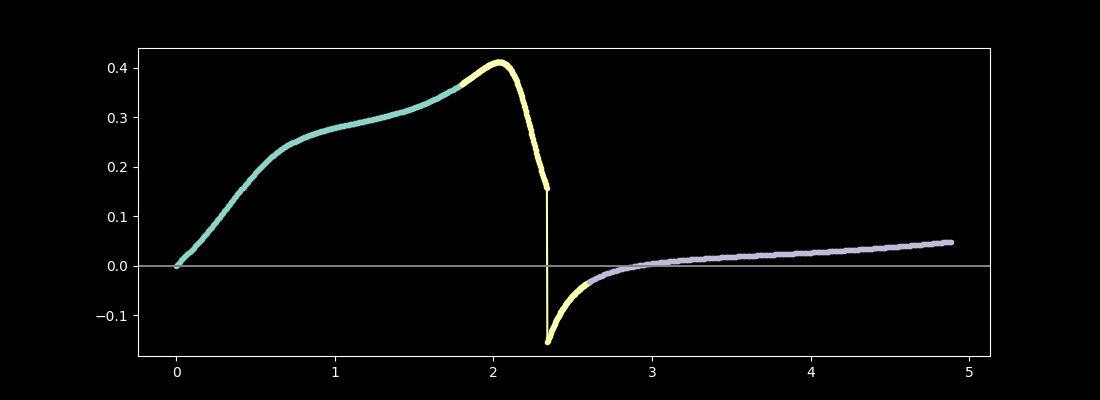

In [47]:
P_sdp1.plot_transform()
P_sdp2.plot_transform(ax=plt.gca())
P_sdp3.plot_transform(ax=plt.gca())

if paper_method:
    P_sdp1o.plot_transform(ax=plt.gca())
    P_sdp2o.plot_transform(ax=plt.gca())
    P_sdp3o.plot_transform(ax=plt.gca())

In [117]:
P_sdp4 = Propagator(A.sdp_contour(A.Z_evanescent.real, 45, 1000), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp4o = Propagator(A.sdp_contour(A.Z_evanescent.real, 45, 1000), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)


In [125]:
P_sdp5 = Propagator(A.sdp_contour(45, 62, 600), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp5o = Propagator(A.sdp_contour(45, 62, 600), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)

In [126]:
P_sdp6 = Propagator(A.sdp_contour(62, 71.5, 1500), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp6o = Propagator(A.sdp_contour(62, 71.5, 1500), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)

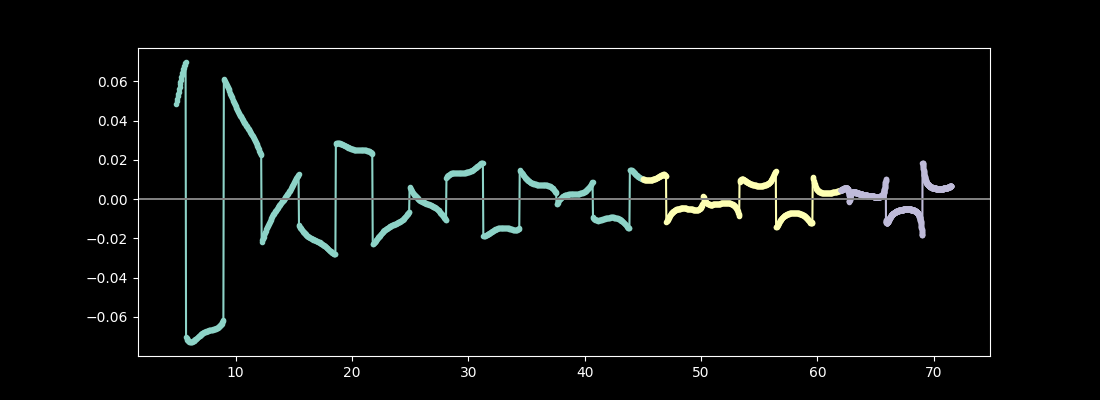

In [127]:
P_sdp4.plot_transform()
P_sdp5.plot_transform(ax=plt.gca())
P_sdp6.plot_transform(ax=plt.gca())

if paper_method:
    P_sdp4o.plot_transform(ax=plt.gca())
    P_sdp5o.plot_transform(ax=plt.gca())
    P_sdp6o.plot_transform(ax=plt.gca())

In [100]:
P_sdp7 = Propagator(A.sdp_contour(71.5, 73., 300), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp7o = Propagator(A.sdp_contour(71.5, 73., 300), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)

In [101]:
P_sdp8 = Propagator(A.sdp_contour(73., 75.2, 300), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp8o = Propagator(A.sdp_contour(73., 75.2, 300), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)

In [102]:
P_sdp9 = Propagator(A.sdp_contour(75.2, 75.4, 300), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp9o = Propagator(A.sdp_contour(75.2, 75.4, 300), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)

In [103]:
P_sdp10 = Propagator(A.sdp_contour(75.4, 78.25, 300), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp10o = Propagator(A.sdp_contour(75.4, 78.25, 300), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)

In [104]:
P_sdp11 = Propagator(A.sdp_contour(78.25, 78.65, 300), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp11o = Propagator(A.sdp_contour(78.25, 78.65, 300), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)

In [105]:
P_sdp12 = Propagator(A.sdp_contour(78.65, 80, 200), f0=f0, Lx=-b, Rx=b, paper_method=paper_method)

if paper_method:
    P_sdp12o = Propagator(A.sdp_contour(78.65, 80, 200), f0=f0, Lx=-b, Rx=b, sign=-1, paper_method=paper_method)

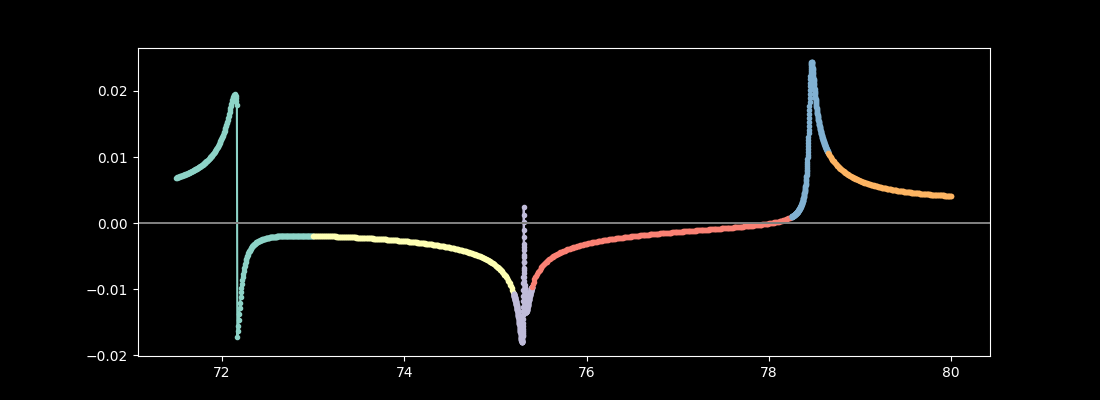

In [128]:
P_sdp7.plot_transform()
P_sdp8.plot_transform(ax=plt.gca())
P_sdp9.plot_transform(ax=plt.gca())
P_sdp10.plot_transform(ax=plt.gca())
P_sdp11.plot_transform(ax=plt.gca())
P_sdp12.plot_transform(ax=plt.gca())

if paper_method:
    P_sdp7o.plot_transform(ax=plt.gca())
    P_sdp8o.plot_transform(ax=plt.gca())
    P_sdp9o.plot_transform(ax=plt.gca())
    P_sdp10o.plot_transform(ax=plt.gca())
    P_sdp11o.plot_transform(ax=plt.gca())
    P_sdp12o.plot_transform(ax=plt.gca())

    # P_sdp4o.plot_transform(ax=plt.gca())

## Forming SDP fields

That was a lot of work to find the fields.  We might be able to cut a few of the above out or reduce their resolution, but it does seem important for what's to follow that we get adequate resolution through 80.  We note too that after 80 the SDP integrals seem to die off, which isn't surprising because by that point we have enclosed all leaky modes.  Question does remain about how far out to go along SDP to get stabilized field and hence have trivial vertical connecting part.

In [196]:
P_sdps = [
    P_sdp1,
    P_sdp2,
    P_sdp3,
    P_sdp4,
    P_sdp5,
    P_sdp6,
    P_sdp7,
    P_sdp8,
    P_sdp9,
    P_sdp10,
    P_sdp11,
    P_sdp12,
]

if paper_method:
    P_sdps.extend(
        [
            P_sdp1o,
            P_sdp2o,
            P_sdp3o,
            P_sdp4o,
            P_sdp5o,
            P_sdp6o,
            P_sdp7o,
            P_sdp8o,
            P_sdp9o,
            P_sdp10o,
            P_sdp11o,
            P_sdp12o,
        ])

In [197]:
sdp_x = lambda x: sum([P.slice_propagate(x, z0, 'z') for P in P_sdps])
sdp_z = lambda z: sum([P.slice_propagate(z, x0, 'x') for P in P_sdps])
Sdp = lambda x, z: sum([P.propagate(x, z) for P in P_sdps]) 

leaky_sdp_x = lambda x: sdp_x(x) + leaky_x(x)
leaky_sdp_z = lambda z: sdp_z(z) + leaky_z(z)

diff_rad_leaky_sdp_x = lambda x: rad_x(x) - leaky_sdp_x(x)
diff_rad_leaky_sdp_z = lambda z: rad_z(z) - leaky_sdp_z(z)

## Combined Leaky-SDP Field Visualizations

At the input end, we expect the difference between the radiation and combined leaky and SDP fields to be equal to the negative of the later vertical portion, the negative having to do with the direction along which we integrate in the complex plane.

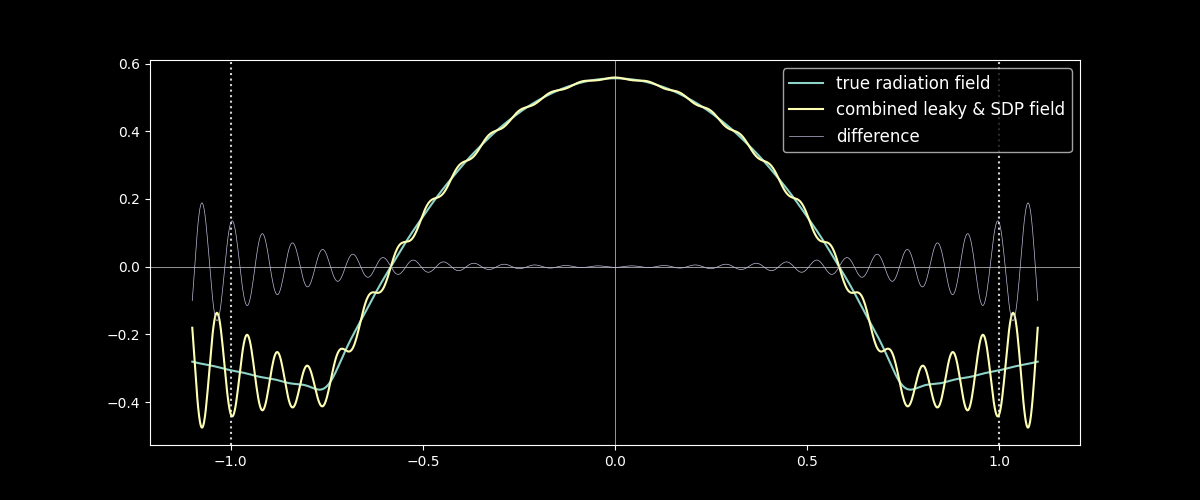

In [199]:
A.plot_field_1d(rad_x, xs=np.linspace(-1.1, 1.1, 1000), label='true radiation field')
A.add_1d_plot(leaky_sdp_x, xs=np.linspace(-1.1, 1.1, 1000), label='combined leaky & SDP field')
A.add_1d_plot(diff_rad_leaky_sdp_x, xs=np.linspace(-1.1, 1.1, 1000), linewidth=.5, label='difference')

In [200]:
# A.plot_field_1d(A.fields_Z(72, mode_type='radiation'), xs=np.linspace(.765, .852,  100))

We expect the difference above to be -vertical later.  Below is the z-propagation

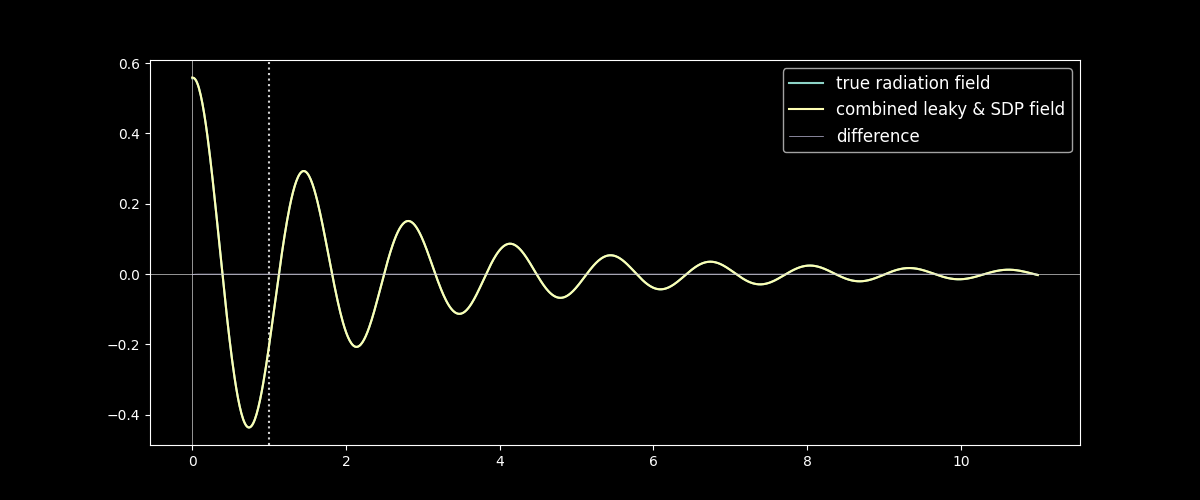

In [62]:
A.plot_field_1d(rad_z, xs=np.linspace(0, 11, 1000), label='true radiation field')
A.add_1d_plot(leaky_sdp_z, xs=np.linspace(0, 11, 1000), label='combined leaky & SDP field')
A.add_1d_plot(diff_rad_leaky_sdp_z, xs=np.linspace(0, 11, 1000), linewidth=.5, label='difference')

We see that the z-propagation is already perfect.  No need for vertical path contribution.  In fact, the vertical path decays extremely quickly in the z direction, so it will be negligible for z-propagation for all but large values of $x$ and small values of $z$.

# Vertical portion

To complete the path integral, we now find the fields associated with the vertical path at $Re(Z)=80$.

In [201]:
P_vertical1 = Propagator(A.vertical_contour_sdp(80, 350, sdp_sign=-1), f0=f0, Lx=-b, Rx=b)

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

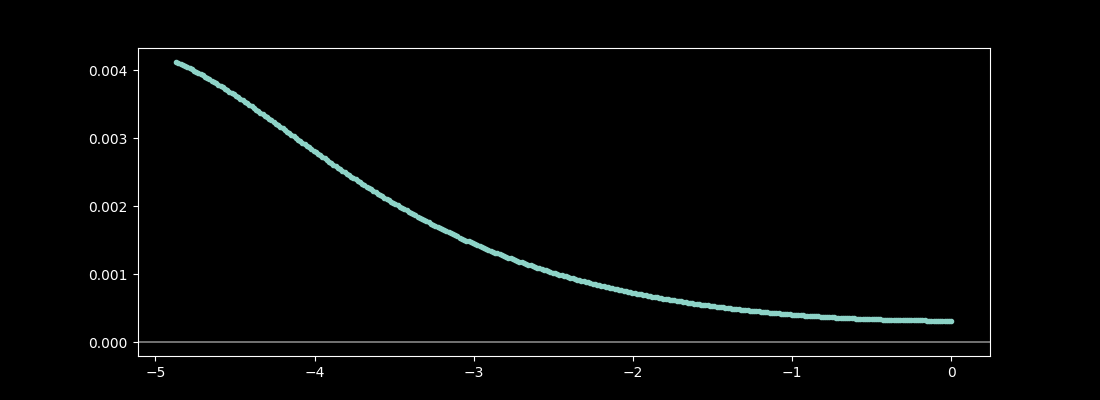

In [202]:
P_vertical1.plot_transform()

In [203]:
P_verticals = [
    P_vertical1,
]

## Forming vertical fields

Same as in other cases

In [204]:
vertical_x = lambda x: sum([P.slice_propagate(x, z0, 'z') for P in P_verticals])
vertical_z = lambda z: sum([P.slice_propagate(z, x0, 'x') for P in P_verticals])
Vertical = lambda x, z: sum([P.propagate(x, z) for P in P_verticals])

leaky_sdp_vertical_x = lambda x: sdp_x(x) + leaky_x(x) - vertical_x(x)
leaky_sdp_vertical_z = lambda z: sdp_z(z) + leaky_z(z) - vertical_z(z)

Full_closed_path = lambda x, z: Rad(x,z) + Vertical(x,z) - Sdp(x,z) - Leaky(x,z)

## Visualizing Vertical Fields

We expect these to be the negative of the difference between the radiation and combined Leaky-SDP fields.

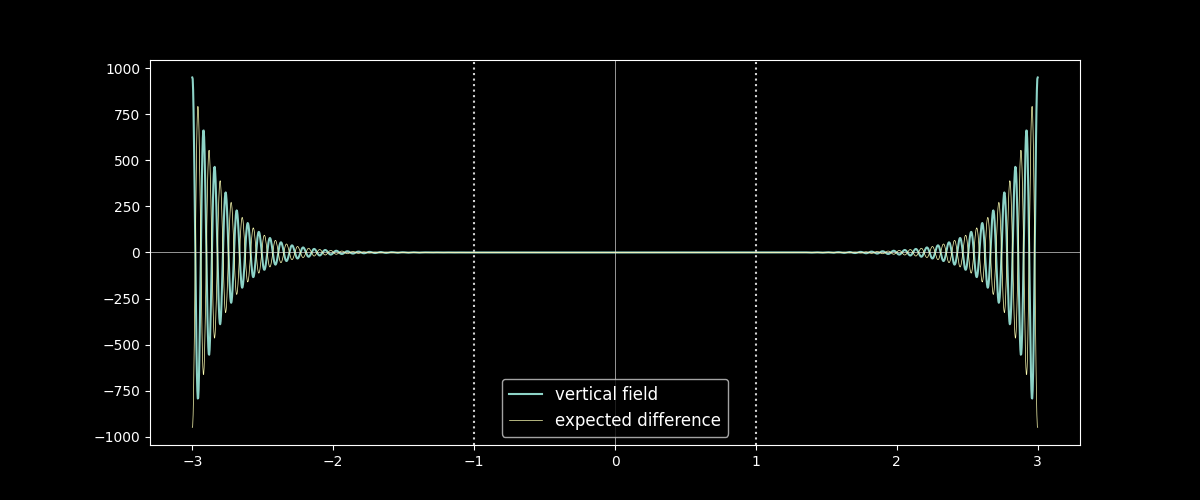

In [205]:
A.plot_field_1d(vertical_x, xs=np.linspace(-3, 3, 2000), label='vertical field')
A.add_1d_plot(diff_rad_leaky_sdp_x, xs=np.linspace(-3, 3, 2000), linewidth=.5, label='expected difference')

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

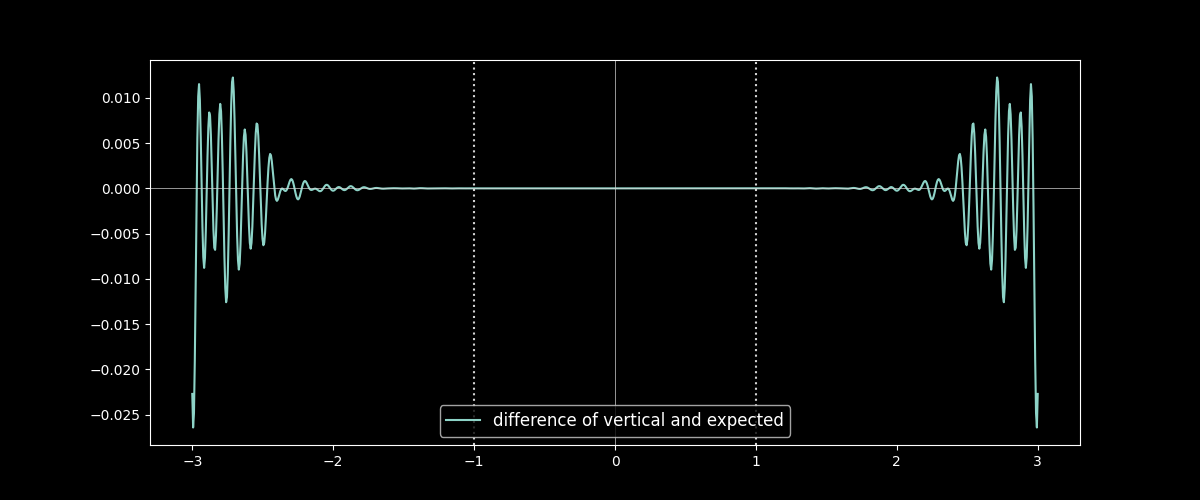

In [206]:
A.plot_field_1d(lambda x: diff_rad_leaky_sdp_x(x) + vertical_x(x), xs=np.linspace(-3, 3, 1000), label='difference of vertical and expected')


Indeed, they are close to equal and opposite.  However, this is dependent on the $x$ variable.

# Visualizations of Total Contour Fields

Based on our direction of integration in the complex plane, we should have Rad + Vert - SDP - Leaky = 0.  Below we see that we do have this by comparing the radiation field to combinded Leaky-SDP-NegativeVertical field.

## At Endface


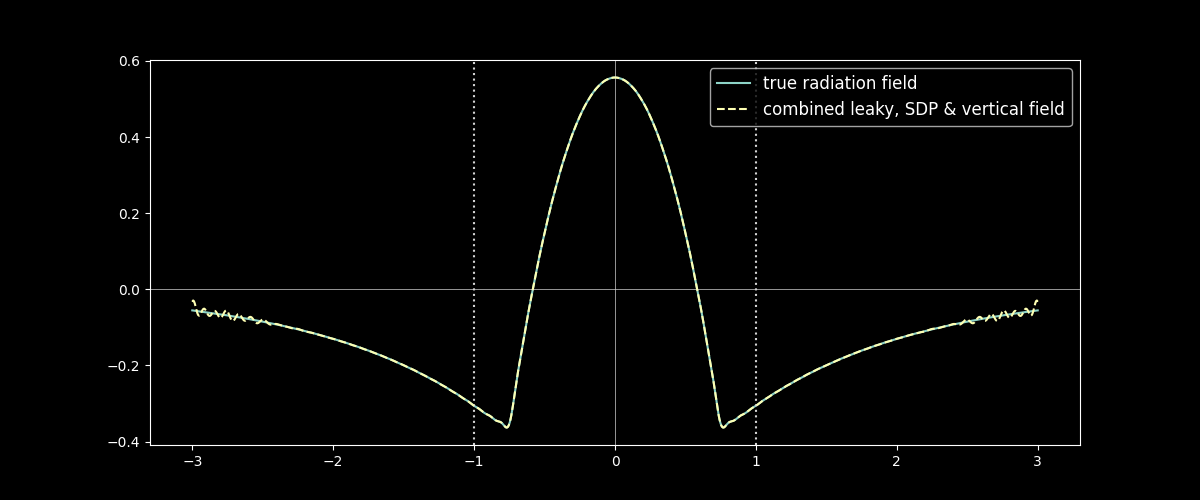

In [207]:
# z0=0
A.plot_field_1d(rad_x, xs=np.linspace(-3, 3, 1000), label='true radiation field')
A.add_1d_plot(leaky_sdp_vertical_x, xs=np.linspace(-3, 3, 1000), linestyle='--', label='combined leaky, SDP & vertical field')

## 2-D Overhead

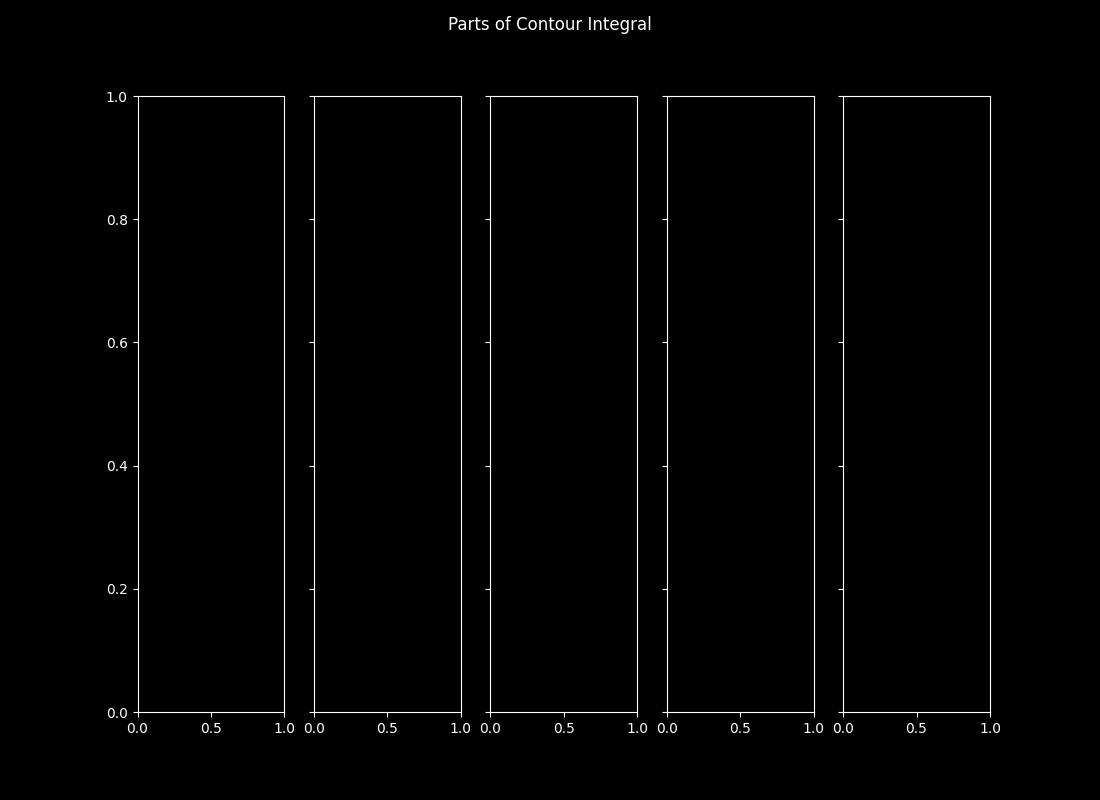

In [208]:
plt.close('all')
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(11,8))

xs = np.linspace(-3,3, 200)
zmin = 0
zmax = 40
zref = int((zmax-zmin)*10)
zs = np.linspace(zmin, zmax, zref)
fig.suptitle('Parts of Contour Integral');

In [209]:
A.add_2d_plot(Full, xs=xs, zs=zs, ax=ax1, colorbar=True, colorbar_format='%0.1f', shrink=.7);
ax1.set_title('Real axis to Z = %.1f' %80)

Text(0.5, 1.0, 'Real axis to Z = 80.0')

In [210]:
A.add_2d_plot(Vertical, xs=xs, zs=zs, ax=ax2, colorbar=True, colorbar_format='%0.1e', colorbar_nticks=2, shrink=.7);
ax2.set_title('Vertical path to SDP')

Text(0.5, 1.0, 'Vertical path to SDP')

In [211]:
A.add_2d_plot(Sdp, xs=xs, zs=zs, ax=ax3, colorbar=True, colorbar_format='%0.1e', colorbar_nticks=2, shrink=.7);
ax3.set_title('SDP portion')

Text(0.5, 1.0, 'SDP portion')

In [212]:
A.add_2d_plot(Leaky, xs=xs, zs=zs, ax=ax4, colorbar=True, colorbar_format='%0.1e', colorbar_nticks=2, shrink=.7);
ax4.set_title('Leaky portion')

Text(0.5, 1.0, 'Leaky portion')

In [213]:
A.add_2d_plot(Full_closed_path, xs=xs, zs=zs, ax=ax5, colorbar=True, colorbar_format='%0.1e', part='norm', colorbar_nticks=2, shrink=.7);
ax5.set_title('Total Path Integral')

Text(0.5, 1.0, 'Total Path Integral')

## Conclulsions and Observations

We have that the contour integration yields the 0 field, as necessary, even in the complex refractive index case.